### 주식 종목 클러스터링 분석 및 시각화
>1. 개요 : 주식 가격의 일 변동성 데이터로 유사한 움직임을 보이는 종목 클러스터링
2. 클러스터링 모델
  * 모델명 : Affinity Propagation
  * 특징 : 군집수 자동 생성, 계산의 복잡성 때문에 중소형 규모의 데이터 사이즈 계산에 적합                                    
  * 데모 참고 : https://goo.gl/PZFgXJ
3. 독특한 시각화 차트 구현
                                    
출처(scikit learn org.) : https://goo.gl/ttdCSA

In [1]:
# 라이브버리 업로드
from datetime import datetime

import numpy as np

# 시각화
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib
from matplotlib import rcParams, style
# style.use('ggplot')
matplotlib.rc('font', family='Malgun Gothic')  # 차트에 한글 사용

# 구글파이낸스에서 주식 데이터 가져오기
from six.moves.urllib.request import urlopen
from six.moves.urllib.parse import urlencode

# 군집분석
from sklearn import cluster, covariance, manifold

In [2]:
# 구글 파이낸스 주가 데이터 수집 함수 : 코스피 시가총액 상위 50종목

## Retrieve the data from Internet
def quotes_historical_google(symbol, date1, date2):
    """Get the historical data from Google finance.

    Parameters
    ----------
    symbol : str
        Ticker symbol to query for, for example ``"DELL"``.
    date1 : datetime.datetime
        Start date.
    date2 : datetime.datetime
        End date.

    Returns
    -------
    X : array
        The columns are ``date`` -- datetime, ``open``, ``high``,
        ``low``, ``close`` and ``volume`` of type float.
    """
    try:
        params = urlencode({
            'q': symbol,
            'startdate': date1.strftime('%b %d, %Y'),
            'enddate': date2.strftime('%b %d, %Y'),
            'output': 'csv'
        })
        url = 'http://www.google.com/finance/historical?' + params
        response = urlopen(url)
        dtype = {
            'names': ['date', 'open', 'high', 'low', 'close', 'volume'],
            'formats': ['object', 'f4', 'f4', 'f4', 'f4', 'f4']
        }
        converters = {0: lambda s: datetime.strptime(s.decode(), '%d-%b-%y')}        
        return np.genfromtxt(response, delimiter=',', skip_header=1,
                             dtype=dtype, converters=converters,
                             missing_values='-', filling_values=-1)
    
    except:  # 구글 파이낸스 오류시 종목 코드 출력하기
        print(symbol)   

In [3]:
# 종목별 일간 가격 데이터 => 일 변동성 데이터 생성
d1 = datetime(2016, 1, 2)  # 시작일
d2 = datetime(2017, 6, 30) # 종료일

symbol_dict = {
    'KRX:005930': '삼성전자',
    'KRX:000660': 'SK하이닉스',
    'KRX:005380': '현대차',
    'KRX:005490': 'POSCO',
    'KRX:035420': 'NAVER',
    'KRX:015760': '한국전력',
    'KRX:028260': '삼성물산',
    'KRX:032830': '삼성생명',   # 상장일자 : 2014.12.18
    'KRX:012330': '현대모비스',
    'KRX:055550': '신한지주',
    'KRX:105560': 'KB금융',
    'KRX:051910': 'LG화학',
    'KRX:017670': 'SK텔레콤',
    'KRX:034730': 'SK',
    'KRX:090430': '아모레퍼시픽',
    'KRX:033780': 'KT&G',
    'KRX:096770': 'SK이노베이션',
    'KRX:051900': 'LG생활건강',
    'KRX:000270': '기아차',
    'KRX:018260': '삼성SDS',   # 상장일자 : 2014.11.14
    'KRX:086790': '하나금융지주',
    'KRX:000810': '삼성화재',
    'KRX:034220': 'LG디스플레이',
    'KRX:003550': 'LG',
    'KRX:000030': '우리은행',
    'KRX:006400': '삼성SDI',
    'KRX:011170': '롯데케미칼',
    'KRX:010950': 'S-Oil',
    'KRX:066570': 'LG전자',
    'KRX:002790': '아모레G',
    # 'KRX:009540': '현대중공업', # 구글 수집 불가
    'KRX:023530': '롯데쇼핑',  
    'KRX:030200': 'KT',
    'KRX:010130': '고려아연',
    'KRX:004020': '현대제철',
    'KRX:161390': '한국타이어',
    'KRX:024110': '기업은행',
    'KRX:036570': '엔씨소프트',   
    'KRX:009150': '삼성전기', 
    'KRX:035250': '강원랜드', 
    'KRX:006800': '미래에셋대우', 
    'KRX:021240': '코웨이', 
    # 'KRX:035720': '카카오',    # 구글 수집 불가
    'KRX:032640': 'LG유플러스', 
    'KRX:139480': '이마트', 
    'KRX:078930': 'GS', 
    'KRX:088350': '한화생명'
    }

symbols, names = np.array(list(symbol_dict.items())).T

quotes = [
    quotes_historical_google(symbol, d1, d2) for symbol in symbols
]

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices    # 일변동성 데이터 생성(고가-저가)

In [10]:
# 데이터 생긴 모습을 보자~!
print("일변동성 데이터 형태(행X열) : ", variation.shape)
variation[:10]

일변동성 데이터 형태(행X열) :  (45, 368)


array([[  2000.,  -5000.,   5000., ..., -33000.,   6000., -55000.],
       [     0.,    600.,   -900., ...,    150.,    100.,   -400.],
       [     0.,   1500.,      0., ...,  -4000.,    500.,  -3500.],
       ..., 
       [ -1500.,   2000.,  -1000., ...,  -2500.,    500.,  -3000.],
       [ -4500.,   1000.,   -500., ...,  -1000.,   3000.,  -4000.],
       [  -900.,      0.,   1300., ...,      0.,    100.,      0.]], dtype=float32)

In [ ]:
'''
# 시가 오류나는 건 체크 : 현대중공업
for i, k in enumerate(range(len(quotes))):
    print(i, names[i], len(quotes[i]['open']))
'''

In [4]:
# 클러스터링 작업 수행 및 결과 출력
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# Cluster using affinity propagation
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: 삼성생명, 삼성화재
Cluster 2: NAVER, 신한지주, KB금융, 하나금융지주, 우리은행, 기업은행, 한화생명
Cluster 3: 아모레퍼시픽, LG생활건강, 아모레G
Cluster 4: SK이노베이션, S-Oil, GS
Cluster 5: 현대차, 현대모비스, 기아차
Cluster 6: 삼성물산, SK, 삼성SDS
Cluster 7: LG디스플레이, LG, LG전자, 롯데쇼핑, 엔씨소프트
Cluster 8: 한국전력, SK텔레콤, KT, LG유플러스
Cluster 9: POSCO, LG화학, 롯데케미칼, 고려아연, 현대제철, 한국타이어, 미래에셋대우
Cluster 10: 삼성전자, SK하이닉스, 삼성SDI, 삼성전기
Cluster 11: KT&G, 강원랜드, 코웨이, 이마트


In [5]:
# 시각화 기초 작업
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

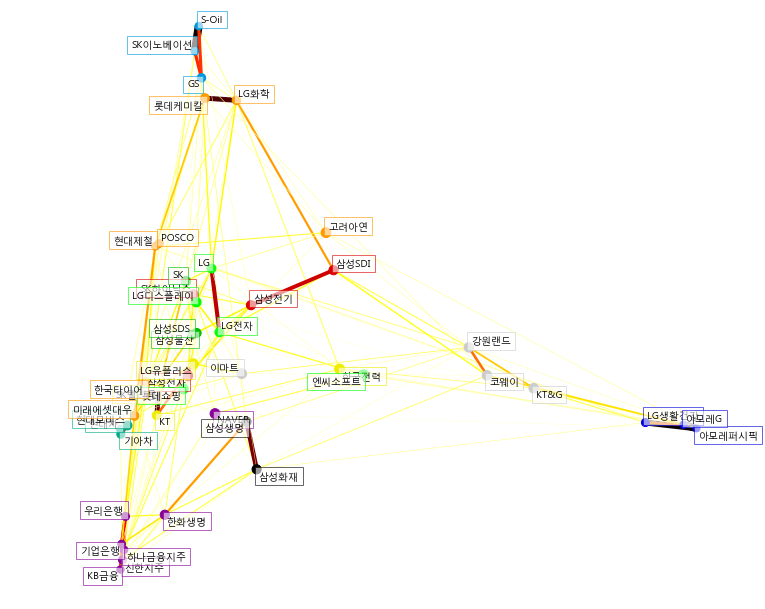

In [6]:
### 차트 구현
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()